# Notebook to visualize training transforms for SELMA3D data

## Setup

In [10]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tifffile as tiff

from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    MapTransform,
    RandAffined,
    RandFlipd,
    RandGaussianNoised,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ToTensord
)
from monai.data import Dataset, DataLoader


In [11]:
# set seed for reproducibility
random.seed(100)


In [12]:
# define paths to data
data_root = '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches'
data_types = ['ab_plaque', 'cfos', 'nucleus', 'vessel_eb', 'vessel_wga']


In [13]:
# choose N random files of each type
N = 3
samples = []
for dtype in data_types:
    folder = os.path.join(data_root, dtype)
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tiff')]
    selected_files = random.sample(files, min(N, len(files)))
    samples += [{'image': f, 'label': dtype} for f in selected_files]

samples


[{'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/ab_plaque/ab_plaque_sample2_C01_p2936.tiff',
  'label': 'ab_plaque'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/ab_plaque/ab_plaque_sample4_C01_p5863.tiff',
  'label': 'ab_plaque'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/ab_plaque/ab_plaque_sample1_C01_p12455.tiff',
  'label': 'ab_plaque'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/cfos/cfos_sample1_C01_p4775.tiff',
  'label': 'cfos'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/cfos/cfos_sample5_C01_p2334.tiff',
  'label': 'cfos'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/cfos/cfos_sample7_C01_p2280.tiff',
  'label': 'cfos'},
 {'image': '/midtier/paetzollab/scratch/ads4015/data_selma3d/small_patches/nucleus/nucleus_sample3_C01_p76493.tiff',
  'label': 'nucleus'},
 {'image': '/midtier/paetzollab/sc

In [14]:
# custom loader for tiff files
class LoadTiffd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        img = tiff.imread(d['image'])
        if img.ndim == 3:
            img = np.expand_dims(img, axis=0) # add channel first
        d['image'] = img
        return d
    

## Transforms

In [15]:
# define training transforms
train_transforms = Compose([
    LoadTiffd(keys=['image']),
    RandFlipd(keys=['image'], spatial_axis=[0, 1, 2], prob=0.5),
    RandAffined(keys=['image'], rotate_range=(0.1, 0.1, 0.1), scale_range=(0.1, 0.1, 0.1), prob=0.5),
    RandGaussianNoised(keys=['image'], prob=0.3, mean=0.0, std=0.01),
    RandScaleIntensityd(keys=['image'], factors=0.2, prob=0.5),
    RandShiftIntensityd(keys=['image'], offsets=0.1, prob=0.5),
    ToTensord(keys=['image'])
])


In [16]:
# define transforms for original (visualization only)
load_transforms = Compose([
    LoadTiffd(keys=['image']),
    ToTensord(keys=['image'])
])


## Visualize

In [26]:
# visualize original image and transforms
def visualize_patch(original, augmented, label, idx, filepath):

    # define center slice
    center_z = original.shape[1] // 2

    # get filename from filepath
    filename = os.path.splitext(os.path.basename(filepath))[0]

    # create plot
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(filename, fontsize=14)

    # plot original
    axs[0].imshow(original[0, center_z], cmap='gray')
    axs[0].set_title(f'Original')
    axs[1].imshow(augmented[0, center_z], cmap='gray')
    axs[1].set_title('Augmented')

    # format and show figure
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    # plt.savefig(f'preview_{label}_{idx}.png') # uncomment this line to save sample images to file
    plt.show()
    

## Apply

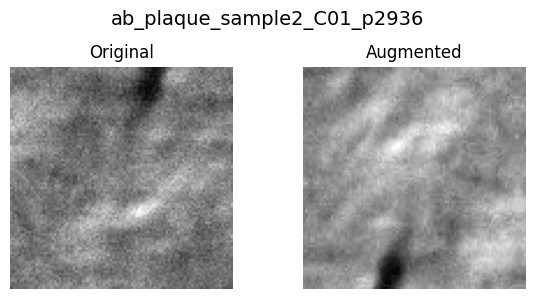

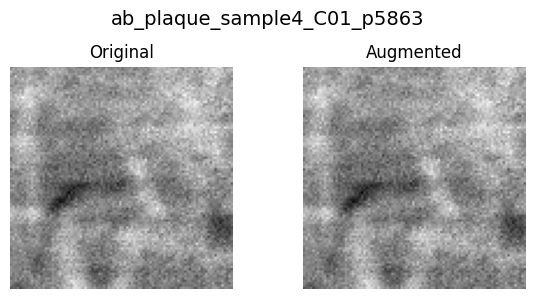

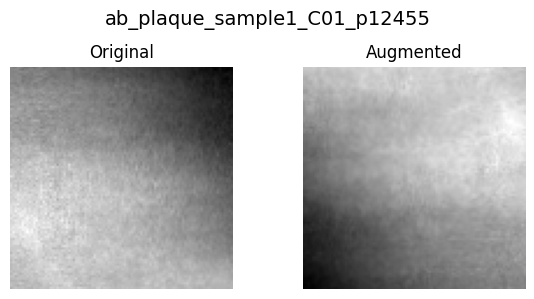

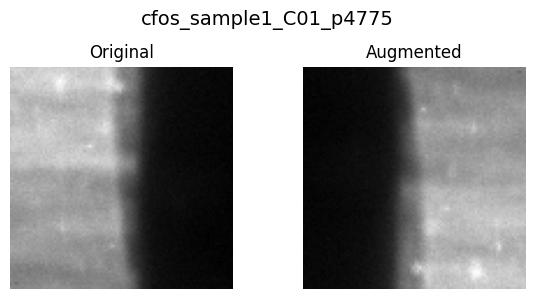

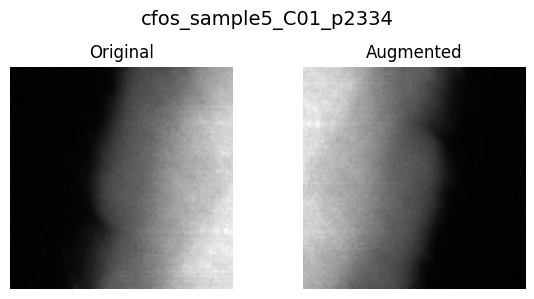

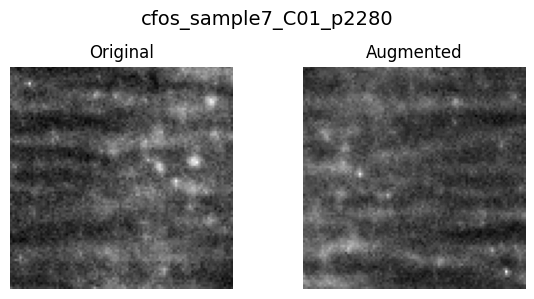

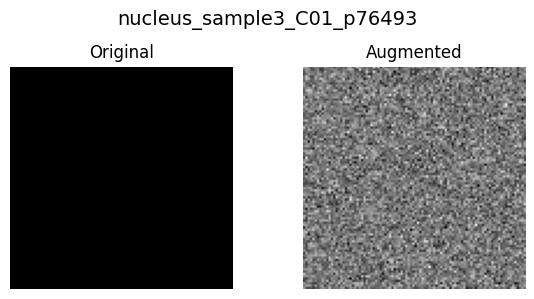

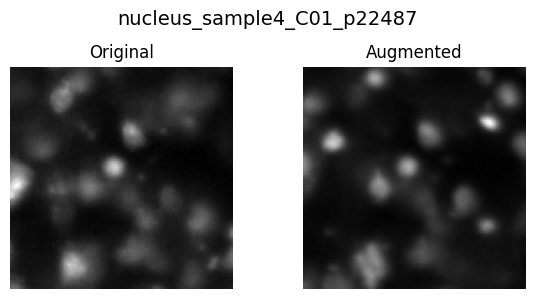

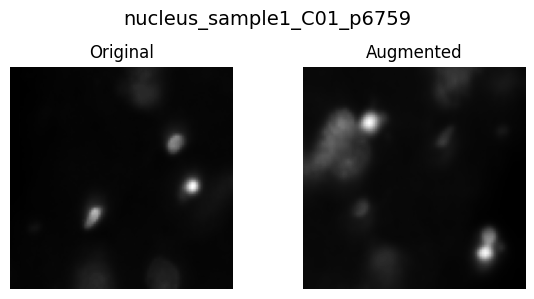

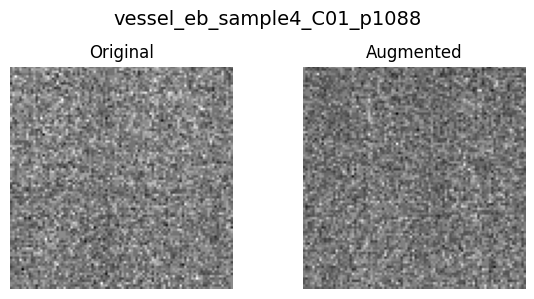

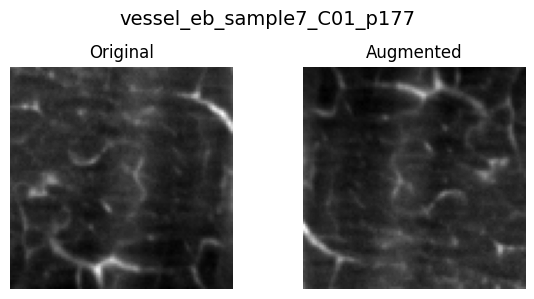

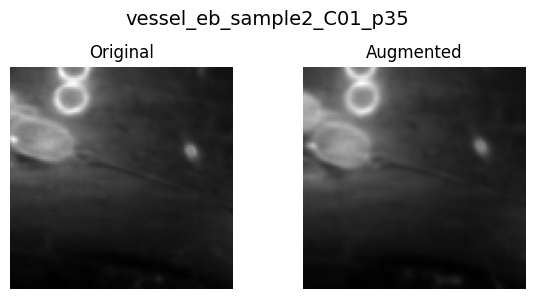

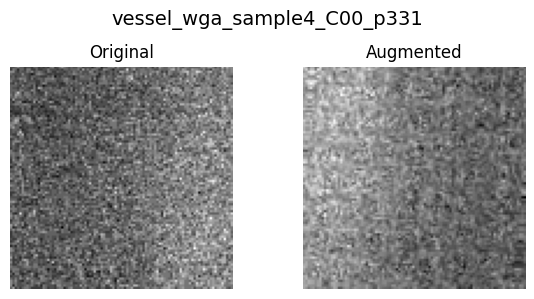

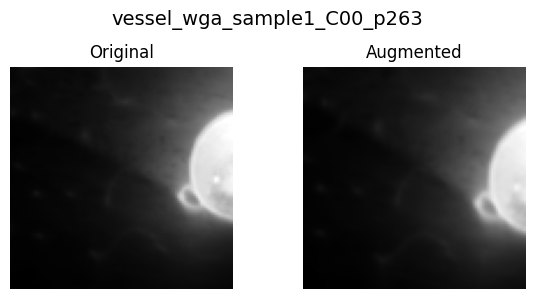

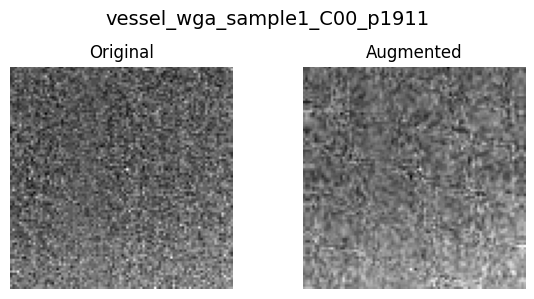

In [27]:
# loop through images and apply transformations
for i, samp in enumerate(samples):

    original = load_transforms(samp)['image']
    augmented = train_transforms(samp)['image']
    visualize_patch(original.numpy(), augmented.numpy(), samp['label'], i, samp['image'])
